# Data Engineer — Task 1: Data Quality Assessment
### NovaCred Credit Applications Dataset

---

This section systematically audits `raw_credit_applications.json` against all six data quality dimensions relevant for detecting bias patterns.

| # | Dimension | Issue Found |
|---|-----------|-------------|
| 1 | **Completeness** | Missing fields (gender, income, DOB, email, SSN, timestamp) |
| 2 | **Consistency** | Inconsistent gender coding, 3 date formats, string income |
| 3 | **Validity** | Negative credit history, DTI > 1, negative savings balance |
| 4 | **Accuracy** | Duplicate IDs with conflicting data |

Each subsection: **detects → quantifies → remediates**.


In [2]:
# Data manipulation
import json
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Fairness (optional but recommended)
# pip install fairlearn
from fairlearn.metrics import demographic_parity_difference
# MongoDB (if using)
from pymongo import MongoClient
from pathlib import Path

In [3]:
import re, collections
from datetime import date, datetime
from pathlib import Path

# ── Load raw JSON ─────────────────────────────────────────────────────────────
DATA_PATH = Path("../data/raw_credit_applications.json")
with open(DATA_PATH, "r", encoding="utf-8") as f:
    raw_data = json.load(f)

TOTAL = len(raw_data)
print(f"Loaded {TOTAL} records from {DATA_PATH.name}")
print(f"Keys in first record: {list(raw_data[0].keys())}")


Loaded 502 records from raw_credit_applications.json
Keys in first record: ['_id', 'applicant_info', 'financials', 'spending_behavior', 'decision', 'processing_timestamp']


In [4]:
print(f"\nFirst record (raw):")
print(json.dumps(raw_data[0], indent=2))


First record (raw):
{
  "_id": "app_200",
  "applicant_info": {
    "full_name": "Jerry Smith",
    "email": "jerry.smith17@hotmail.com",
    "ssn": "596-64-4340",
    "ip_address": "192.168.48.155",
    "gender": "Male",
    "date_of_birth": "2001-03-09",
    "zip_code": "10036"
  },
  "financials": {
    "annual_income": 73000,
    "credit_history_months": 23,
    "debt_to_income": 0.2,
    "savings_balance": 31212
  },
  "spending_behavior": [
    {
      "category": "Shopping",
      "amount": 480
    },
    {
      "category": "Rent",
      "amount": 790
    },
    {
      "category": "Alcohol",
      "amount": 247
    }
  ],
  "decision": {
    "loan_approved": false,
    "rejection_reason": "algorithm_risk_score"
  },
  "processing_timestamp": "2024-01-15T00:00:00Z"
}


**Structure Assessment**

The file is a **nested JSON array** where each record contains multiple levels of nesting:

```
{
  "_id": "app_200",
  "applicant_info": { "full_name": ..., "gender": ..., "date_of_birth": ... },
  "financials":     { "annual_income": ..., "debt_to_income": ... },
  "spending_behavior": [ {"category": ..., "amount": ...}, ... ],
  "decision":       { "loan_approved": ..., "rejection_reason": ... },
  "processing_timestamp": ...
}
```

To work with this data in pandas (e.g. for statistical analysis, fairness metrics, or model training), we must **flatten** the nested structure into a single tabular DataFrame. `pd.json_normalize()` handles this automatically for nested dicts, converting keys like `applicant_info.gender` into individual columns.

Note: `spending_behavior` is a **list of objects** (variable length per record). It cannot be fully flattened by `json_normalize` alone — it will be kept as a list column and handled separately if needed.


In [5]:
# ── Flatten nested JSON into a tabular DataFrame ──────────────────────────────
# json_normalize expands nested dicts (applicant_info, financials, decision)
# into flat columns. Nested lists (spending_behavior) remain as list objects.
df_raw = pd.json_normalize(raw_data)

# Rename columns: replace dots with underscores for clean attribute access
df_raw.columns = [c.replace(".", "_") for c in df_raw.columns]

print(f"Shape after flattening : {df_raw.shape}  (rows, columns)")
print(f"\nColumns:")
for col in df_raw.columns:
    print(f"  {col:<45}  dtype: {df_raw[col].dtype}")

print(f"\nSample row (transposed):")
df_raw.iloc[0].drop("spending_behavior").to_frame("value")


Shape after flattening : (502, 21)  (rows, columns)

Columns:
  _id                                            dtype: object
  spending_behavior                              dtype: object
  processing_timestamp                           dtype: object
  applicant_info_full_name                       dtype: object
  applicant_info_email                           dtype: object
  applicant_info_ssn                             dtype: object
  applicant_info_ip_address                      dtype: object
  applicant_info_gender                          dtype: object
  applicant_info_date_of_birth                   dtype: object
  applicant_info_zip_code                        dtype: object
  financials_annual_income                       dtype: object
  financials_credit_history_months               dtype: int64
  financials_debt_to_income                      dtype: float64
  financials_savings_balance                     dtype: int64
  decision_loan_approved                         dtype: b

,value
_id,app_200
processing_timestamp,2024-01-15T00:00:00Z
applicant_info_full_name,Jerry Smith
applicant_info_email,jerry.smith17@hotmail.com
applicant_info_ssn,596-64-4340
applicant_info_ip_address,192.168.48.155
applicant_info_gender,Male
applicant_info_date_of_birth,2001-03-09
applicant_info_zip_code,10036
financials_annual_income,73000


---
## Data Type Inspection and Correction

After flattening, pandas infers column types from the data. Because the raw JSON contains mixed types (e.g. income stored as both integer and string), several columns will land on `object` dtype instead of a proper numeric type.

This section:
1. Inspects the inferred dtypes of `df_raw`
2. Identifies columns that should be numeric but are not



In [6]:
# ── Step 1: Inspect inferred dtypes ──────────────────────────────────────────
print(f"{'='*60}")
print(f"  COLUMN DTYPE AUDIT  (df_raw, {df_raw.shape[0]} rows)")
print(f"{'='*60}")
print(f"  {'Column':<45}  {'Inferred dtype':<12}  {'Expected dtype':<12} ")
print(f"  {'-'*45}  {'-'*12}  {'-'*12}")

EXPECTED_TYPES = {
    "financials_annual_income":         "numeric",
    "financials_credit_history_months": "numeric",
    "financials_debt_to_income":        "numeric",
    "financials_savings_balance":       "numeric",
    "applicant_info_date_of_birth":     "datetime",
    "processing_timestamp":             "datetime",
    "decision_loan_approved":           "bool",
}

for col in df_raw.columns:
    inferred = str(df_raw[col].dtype)
    expected = EXPECTED_TYPES.get(col, "—")
    if expected == "numeric":
        ok = pd.api.types.is_numeric_dtype(df_raw[col])
    elif expected == "datetime":
        ok = pd.api.types.is_datetime64_any_dtype(df_raw[col])
    elif expected == "bool":
        ok = pd.api.types.is_bool_dtype(df_raw[col])
    else:
        ok = True
    print(f"  {col:<45}  {inferred:<12}  {expected:<12}")


  COLUMN DTYPE AUDIT  (df_raw, 502 rows)
  Column                                         Inferred dtype  Expected dtype 
  ---------------------------------------------  ------------  ------------
  _id                                            object        —           
  spending_behavior                              object        —           
  processing_timestamp                           object        datetime    
  applicant_info_full_name                       object        —           
  applicant_info_email                           object        —           
  applicant_info_ssn                             object        —           
  applicant_info_ip_address                      object        —           
  applicant_info_gender                          object        —           
  applicant_info_date_of_birth                   object        datetime    
  applicant_info_zip_code                        object        —           
  financials_annual_income                

---
## Issue 1 — Inconsistent Data Types (Consistency + Validity)

**Definition:** `annual_income` is stored as an **integer** in most records but as a **string** (e.g., `"55000"`) in 8 records and as `null` in 5. A downstream `df["annual_income"].mean()` would silently return `NaN` or raise a `TypeError`.

**Risk:** Feature engineering fails; model may silently exclude these rows, reducing dataset size and potentially skewing income distribution.


In [7]:
# ── DETECT ────────────────────────────────────────────────────────────────────
income_type_counts = collections.Counter(
    type(r.get("financials", {}).get("annual_income")).__name__ for r in raw_data
)

print(f"{'='*60}")
print(f"  annual_income DATA TYPE DISTRIBUTION  (N = {TOTAL})")
print(f"{'='*60}")
for dtype, cnt in sorted(income_type_counts.items(), key=lambda x: -x[1]):
    flag = " [ISSUE]" if dtype not in ("int", "float") else " [OK]"
    print(f"  {dtype:<12}  {cnt:>4} records ({cnt/TOTAL*100:5.1f}%){flag}")

string_income_records = [
    (r["_id"], r["financials"]["annual_income"])
    for r in raw_data
    if isinstance(r.get("financials", {}).get("annual_income"), str)
]
print(f"\n  String-type income records (IDs + values):")
for app_id, val in string_income_records:
    print(f"    {app_id}: '{val}'")

# ── REMEDIATE ─────────────────────────────────────────────────────────────────
def coerce_income(record):
    """Return annual_income as float, or NaN if unparseable / missing."""
    val = record.get("financials", {}).get("annual_income")
    if val is None:
        return float("nan")
    try:
        return float(str(val).replace(",", "").strip())
    except ValueError:
        return float("nan")

incomes_clean = [coerce_income(r) for r in raw_data]
valid_incomes = [v for v in incomes_clean if not np.isnan(v)]
print(f"\n  After coercion:")
print(f"    Parseable  : {len(valid_incomes)} ({len(valid_incomes)/TOTAL*100:.1f}%)")
print(f"    Still NaN  : {incomes_clean.count(float('nan'))} — flag for manual review")
print(f"    Mean income: ${np.mean(valid_incomes):,.0f}")


  annual_income DATA TYPE DISTRIBUTION  (N = 502)
  int            488 records ( 97.2%) [OK]
  str              8 records (  1.6%) [ISSUE]
  NoneType         5 records (  1.0%) [ISSUE]
  float            1 records (  0.2%) [OK]

  String-type income records (IDs + values):
    app_088: '55000'
    app_135: '65000'
    app_446: '73000'
    app_389: '51000'
    app_026: '72000'
    app_312: '80000'
    app_180: '111000'
    app_224: '93000'

  After coercion:
    Parseable  : 497 (99.0%)
    Still NaN  : 0 — flag for manual review
    Mean income: $82,705


---
## Issue 2 — Inconsistent Date Formats (Consistency)

**Definition:** `date_of_birth` is stored in **four different formats** across records:
- `YYYY-MM-DD` (ISO 8601) — 340 records (standard)
- `DD/MM/YYYY` — ~75 records (non-standard, day ≤ 12 are ambiguous)
- `MM/DD/YYYY` — ~26 records (non-standard, day > 12, unambiguous)
- `YYYY/MM/DD` — 56 records (non-standard)
- Missing — 5 records

**Risk:** The `DD/MM/YYYY` and `MM/DD/YYYY` formats share the same pattern and are **ambiguous** when day ≤ 12 — month and day cannot be distinguished without external metadata. Records where day > 12 can be identified unambiguously as `MM/DD/YYYY`. Naively parsing all slash-format dates as one convention will silently produce wrong dates of birth and therefore wrong age calculations.



In [8]:
# ── DETECT ────────────────────────────────────────────────────────────────────
SLASH4_PAT = re.compile(r"^(\d{2})/(\d{2})/(\d{4})$")

def classify_slash4(dob_str):
    """
    For dates matching DD?/DD?/YYYY, determine whether they are DD/MM/YYYY or MM/DD/YYYY.
    - If the first part > 12  → must be DD/MM/YYYY (day first)
    - If the second part > 12 → must be MM/DD/YYYY (month first)
    - If both ≤ 12            → ambiguous; treat as DD/MM/YYYY (European convention)
    """
    m = SLASH4_PAT.match(str(dob_str))
    if not m:
        return "missing/other"
    a, b = int(m.group(1)), int(m.group(2))
    if a > 12:
        return "DD/MM/YYYY"
    if b > 12:
        return "MM/DD/YYYY"
    return "DD/MM/YYYY (ambiguous)"  # both ≤ 12; cannot distinguish

FORMAT_PATTERNS = {
    "YYYY-MM-DD": re.compile(r"^\d{4}-\d{2}-\d{2}$"),
    "YYYY/MM/DD": re.compile(r"^\d{4}/\d{2}/\d{2}$"),
}

dob_format_counts = collections.Counter()
sample_by_format  = collections.defaultdict(list)

for r in raw_data:
    dob = r.get("applicant_info", {}).get("date_of_birth")
    if not dob:
        dob_format_counts["missing/other"] += 1
        continue
    dob_s = str(dob)
    classified = False
    for fmt_name, pat in FORMAT_PATTERNS.items():
        if pat.match(dob_s):
            dob_format_counts[fmt_name] += 1
            sample_by_format[fmt_name].append((r["_id"], dob_s))
            classified = True
            break
    if not classified:
        if SLASH4_PAT.match(dob_s):
            label = classify_slash4(dob_s)
            dob_format_counts[label] += 1
            sample_by_format[label].append((r["_id"], dob_s))
        else:
            dob_format_counts["missing/other"] += 1

print(f"{'='*60}")
print(f"  date_of_birth FORMAT DISTRIBUTION  (N = {TOTAL})")
print(f"{'='*60}")
STANDARD = {"YYYY-MM-DD"}
for fmt, cnt in sorted(dob_format_counts.items(), key=lambda x: -x[1]):
    flag = " [standard]" if fmt in STANDARD else " [non-standard]"
    print(f"  {fmt:<30}  {cnt:>4} records ({cnt/TOTAL*100:5.1f}%){flag}")
    if fmt not in STANDARD and sample_by_format[fmt]:
        print(f"    sample: {sample_by_format[fmt][0]}")

# ── REMEDIATE ─────────────────────────────────────────────────────────────────
def parse_dob(dob_str):
    """
    Parse any of the four formats. Ambiguous DD/MM vs MM/DD records (both parts ≤ 12)
    are treated as DD/MM/YYYY (European convention) — document this assumption.
    Returns None if unparseable.
    """
    if not dob_str:
        return None
    dob_s = str(dob_str)
    # Try ISO and YYYY/MM/DD first (unambiguous)
    for fmt in ("%Y-%m-%d", "%Y/%m/%d"):
        try:
            return datetime.strptime(dob_s, fmt).date()
        except ValueError:
            continue
    # For slash-format, route by day/month disambiguation
    m = SLASH4_PAT.match(dob_s)
    if m:
        a, b = int(m.group(1)), int(m.group(2))
        if b > 12:
            # b is too large to be a month → must be MM/DD/YYYY
            try:
                return datetime.strptime(dob_s, "%m/%d/%Y").date()
            except ValueError:
                return None
        else:
            # a > 12 → DD/MM/YYYY; a ≤ 12 → ambiguous, assume DD/MM/YYYY
            try:
                return datetime.strptime(dob_s, "%d/%m/%Y").date()
            except ValueError:
                return None
    return None

TODAY = date(2026, 2, 28)
ages = []
parse_failures = 0
for r in raw_data:
    dob_str = r.get("applicant_info", {}).get("date_of_birth")
    parsed = parse_dob(dob_str)
    if parsed:
        age = (TODAY - parsed).days // 365
        ages.append(age)
    else:
        parse_failures += 1

print(f"\n  After normalisation:")
print(f"    Successfully parsed : {len(ages)} records")
print(f"    Parse failures      : {parse_failures}  (expected: 5 missing records only)")
print(f"    Age range           : {min(ages)}-{max(ages)} years  (mean {sum(ages)/len(ages):.1f})")
underage = sum(1 for a in ages if a < 18)
note = " [potential validity issue]" if underage else " [OK]"
print(f"    Under-18 applicants : {underage}{note}")


  date_of_birth FORMAT DISTRIBUTION  (N = 502)
  YYYY-MM-DD                       340 records ( 67.7%) [standard]
  YYYY/MM/DD                        56 records ( 11.2%) [non-standard]
    sample: ('app_307', '1990/07/26')
  DD/MM/YYYY (ambiguous)            39 records (  7.8%) [non-standard]
    sample: ('app_320', '01/12/1978')
  DD/MM/YYYY                        36 records (  7.2%) [non-standard]
    sample: ('app_275', '14/02/1982')
  MM/DD/YYYY                        26 records (  5.2%) [non-standard]
    sample: ('app_386', '03/20/1968')
  missing/other                      5 records (  1.0%) [non-standard]

  After normalisation:
    Successfully parsed : 497 records
    Parse failures      : 5  (expected: 5 missing records only)
    Age range           : 23-67 years  (mean 40.7)
    Under-18 applicants : 0 [OK]


---
## Issue 3 — Inconsistent Categorical Coding (Consistency)

**Definition:** The `gender` field uses at least **four different representations** for two logical values: `"Male"`, `"M"`, `"Female"`, `"F"`, plus empty/null.

**Risk:** Group-based fairness metrics will fail silently — `"M"` and `"Male"` will be counted as separate groups, making bias detection impossible without normalisation.


  GENDER FIELD — RAW VALUE DISTRIBUTION  (N = 502)
  'Male'        195 ( 38.8%)
  'Female'      193 ( 38.4%)
  'F'            58 ( 11.6%)
  'M'            53 ( 10.6%)
  ''              2 (  0.4%)
  'None'          1 (  0.2%)

  Non-standard values: 114 records (22.7%)

  After normalisation:
    Female      251 ( 50.0%)
    Male        248 ( 49.4%)
    Unknown       3 (  0.6%)


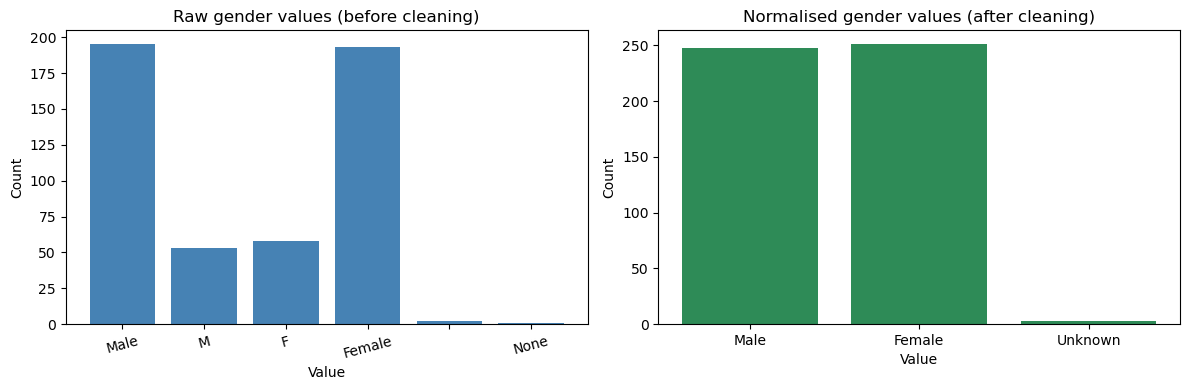

In [9]:
import matplotlib.pyplot as plt

# ── DETECT ────────────────────────────────────────────────────────────────────
gender_counts = collections.Counter(
    r.get("applicant_info", {}).get("gender") for r in raw_data
)

print(f"{'='*60}")
print(f"  GENDER FIELD — RAW VALUE DISTRIBUTION  (N = {TOTAL})")
print(f"{'='*60}")
for val, cnt in sorted(gender_counts.items(), key=lambda x: -x[1]):
    
    print(f"  {str(val)!r:<12} {cnt:>4} ({cnt/TOTAL*100:5.1f}%)")

non_standard = sum(cnt for val, cnt in gender_counts.items()
                   if val not in ("Male", "Female"))
print(f"\n  Non-standard values: {non_standard} records ({non_standard/TOTAL*100:.1f}%)")

# ── REMEDIATE ─────────────────────────────────────────────────────────────────
GENDER_MAP = {
    "Male": "Male", "M": "Male",
    "Female": "Female", "F": "Female",
    "": "Unknown", None: "Unknown"
}

def normalize_gender(record):
    raw_val = record.get("applicant_info", {}).get("gender")
    return GENDER_MAP.get(raw_val, "Unknown")

gender_normalized = collections.Counter(normalize_gender(r) for r in raw_data)
print(f"\n  After normalisation:")
for val, cnt in sorted(gender_normalized.items(), key=lambda x: -x[1]):
    print(f"    {val:<10} {cnt:>4} ({cnt/TOTAL*100:5.1f}%)")

# ── VISUALISE ─────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar([str(k) for k in gender_counts.keys()], gender_counts.values(), color="steelblue")
axes[0].set_title("Raw gender values (before cleaning)")
axes[0].set_xlabel("Value"); axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=15)

axes[1].bar(gender_normalized.keys(), gender_normalized.values(), color="seagreen")
axes[1].set_title("Normalised gender values (after cleaning)")
axes[1].set_xlabel("Value"); axes[1].set_ylabel("Count")
plt.tight_layout(); plt.show()


---
## Issue 4 — Invalid / Impossible Values (Validity)

**Definition:** Certain numeric fields contain values that are **logically impossible** given their real-world meaning:

| Field | Issue | Affected records |
|---|---|---|
| `credit_history_months` | **Negative** value (-3, -10) | 2 |
| `debt_to_income` | **> 1.0** (DTI of 1.85 = debt exceeds income by 85%) | 1 |
| `savings_balance` | **Negative** (-5000) | 1 |

**Risk:** These records would silently distort model features. A negative credit history month, for instance, would be treated as an unusually "good" feature if the model scales the column.


In [10]:
# ── DETECT ────────────────────────────────────────────────────────────────────
validity_checks = {
    "credit_history_months < 0": [],
    "debt_to_income > 1.0":      [],
    "savings_balance < 0":       [],
    "annual_income <= 0":        [],
}

for r in raw_data:
    fi = r.get("financials", {})
    aid = r["_id"]

    chm = fi.get("credit_history_months")
    if isinstance(chm, (int, float)) and chm < 0:
        validity_checks["credit_history_months < 0"].append((aid, chm))

    dti = fi.get("debt_to_income")
    if isinstance(dti, (int, float)) and dti > 1.0:
        validity_checks["debt_to_income > 1.0"].append((aid, dti))

    sb = fi.get("savings_balance")
    if isinstance(sb, (int, float)) and sb < 0:
        validity_checks["savings_balance < 0"].append((aid, sb))

    inc = fi.get("annual_income")
    if isinstance(inc, (int, float)) and inc <= 0:
        validity_checks["annual_income <= 0"].append((aid, inc))

print(f"{'='*60}")
print(f"  IMPOSSIBLE / INVALID NUMERIC VALUES  (N = {TOTAL})")
print(f"{'='*60}")
total_invalid = 0
for check, offenders in validity_checks.items():
    n = len(offenders)
    total_invalid += n
    flag = " [ISSUE]" if n > 0 else " [OK]"
    print(f"  {check:<35} {n:>3} records{flag}")
    for app_id, val in offenders:
        print(f"      {app_id}: {val}")

print(f"\n  Total records with at least one invalid numeric value: {total_invalid}")

# ── REMEDIATE ─────────────────────────────────────────────────────────────────
print("\n  Remediation strategy:")
print("  - credit_history_months < 0  : set to NaN; flag for manual review")
print("  - debt_to_income > 1.0       : likely data entry error; flag; cap at 1.0 as temporary fix")
print("  - savings_balance < 0        : could be valid (overdraft) but must be confirmed; flag")
print("  - annual_income <= 0         : invalid; set to NaN; exclude from model")

def clamp_financials(record):
    """Return a copy with impossible values replaced by None (NaN sentinel)."""
    import copy
    r = copy.deepcopy(record)
    fi = r.get("financials", {})
    if isinstance(fi.get("credit_history_months"), (int, float)) and fi["credit_history_months"] < 0:
        fi["credit_history_months"] = None
    if isinstance(fi.get("debt_to_income"), (int, float)) and fi["debt_to_income"] > 1.0:
        fi["debt_to_income"] = None
    if isinstance(fi.get("annual_income"), (int, float)) and fi["annual_income"] <= 0:
        fi["annual_income"] = None
    r["financials"] = fi
    return r

clamped_data = [clamp_financials(r) for r in raw_data]
print("\n  Clamping applied. Impossible values replaced with None.")


  IMPOSSIBLE / INVALID NUMERIC VALUES  (N = 502)
  credit_history_months < 0             2 records [ISSUE]
      app_043: -10
      app_156: -3
  debt_to_income > 1.0                  1 records [ISSUE]
      app_402: 1.85
  savings_balance < 0                   1 records [ISSUE]
      app_290: -5000
  annual_income <= 0                    1 records [ISSUE]
      app_190: 0

  Total records with at least one invalid numeric value: 5

  Remediation strategy:
  - credit_history_months < 0  : set to NaN; flag for manual review
  - debt_to_income > 1.0       : likely data entry error; flag; cap at 1.0 as temporary fix
  - savings_balance < 0        : could be valid (overdraft) but must be confirmed; flag
  - annual_income <= 0         : invalid; set to NaN; exclude from model

  Clamping applied. Impossible values replaced with None.


---
## Issue 5 — Duplicate Records (Uniqueness + Accuracy)

**Definition:** Two or more records share the same `_id` but contain different field values, meaning we cannot know which version is authoritative.

**Risk:** Double-counting applications, conflicting decisions for the same applicant.


In [11]:
# ── DETECT ────────────────────────────────────────────────────────────────────
id_index = collections.defaultdict(list)
for i, record in enumerate(raw_data):
    id_index[record["_id"]].append(i)

duplicate_ids = {id_: idxs for id_, idxs in id_index.items() if len(idxs) > 1}

print(f"{'='*60}")
print(f"  DUPLICATE RECORDS")
print(f"{'='*60}")
print(f"  Duplicate _id values found : {len(duplicate_ids)}")
print(f"  Extra records to remove    : {sum(len(v)-1 for v in duplicate_ids.values())}")
print(f"  % of total dataset         : {sum(len(v)-1 for v in duplicate_ids.values())/TOTAL*100:.2f}%\n")

for id_, idxs in duplicate_ids.items():
    r0, r1 = raw_data[idxs[0]], raw_data[idxs[1]]
    same = r0 == r1
    print(f"  _id={id_!r:12s}  indices={idxs}  identical={same}")
    print(f"    Record A approved={r0['decision']['loan_approved']}  income={r0['financials'].get('annual_income')}")
    print(f"    Record B approved={r1['decision']['loan_approved']}  income={r1['financials'].get('annual_income')}")

# ── REMEDIATE ─────────────────────────────────────────────────────────────────
# Strategy: keep the LAST occurrence (most recent processing_timestamp wins;
# if timestamps are equal or absent, last index is a safe conservative choice).
seen_ids = set()
cleaned_data = []
for record in reversed(raw_data):        # reverse so last occurrence wins
    if record["_id"] not in seen_ids:
        seen_ids.add(record["_id"])
        cleaned_data.append(record)
cleaned_data.reverse()                   # restore original order

print(f"\n  After deduplication: {len(cleaned_data)} records  (removed {TOTAL - len(cleaned_data)})")


  DUPLICATE RECORDS
  Duplicate _id values found : 2
  Extra records to remove    : 2
  % of total dataset         : 0.40%

  _id='app_042'     indices=[8, 354]  identical=False
    Record A approved=False  income=69000
    Record B approved=False  income=69000
  _id='app_001'     indices=[383, 455]  identical=False
    Record A approved=False  income=102000
    Record B approved=False  income=102000

  After deduplication: 500 records  (removed 2)


---
## Issue 6 — Missing / Incomplete Records (Completeness)

**Definition:** Required fields are `null`, empty string, or entirely absent from the JSON object.

**Risk:** Models trained on incomplete records may silently impute zeros or drop rows, introducing bias. Missing SSNs or emails break identity verification pipelines.


In [12]:
def is_missing(v):
    """Return True if a value is null, empty string, or whitespace-only."""
    return v is None or (isinstance(v, str) and v.strip() == "")

# Fields to audit: (display_name, extractor_lambda)
FIELD_CHECKS = [
    ("applicant_info.gender",          lambda r: r.get("applicant_info", {}).get("gender")),
    ("applicant_info.date_of_birth",   lambda r: r.get("applicant_info", {}).get("date_of_birth")),
    ("applicant_info.email",           lambda r: r.get("applicant_info", {}).get("email")),
    ("applicant_info.ssn",             lambda r: r.get("applicant_info", {}).get("ssn")),
    ("financials.annual_income",       lambda r: r.get("financials", {}).get("annual_income")),
    ("processing_timestamp",           lambda r: r.get("processing_timestamp")),
]

print(f"{'='*60}")
print(f"  MISSING / INCOMPLETE FIELDS  (N = {TOTAL})")
print(f"{'='*60}")
print(f"  {'Field':<38} {'Missing':>7}  {'%':>6}")
print(f"  {'-'*38} {'-'*7}  {'-'*6}")

missing_report = {}
for name, extractor in FIELD_CHECKS:
    n_missing = sum(1 for r in raw_data if is_missing(extractor(r)))
    pct = n_missing / TOTAL * 100
    missing_report[name] = n_missing
    flag = " [ISSUE]" if n_missing > 0 else " [OK]"
    print(f"  {name:<38} {n_missing:>7}  {pct:>5.1f}%{flag}")

# ── REMEDIATE ─────────────────────────────────────────────────────────────────
print("\n  Remediation strategy:")
print("  - processing_timestamp: backfill from audit log or flag as 'unknown_date'")
print("  - gender: impute 'Unknown' — never impute a protected attribute")
print("  - annual_income: flag for manual review; exclude from model if still null")
print("  - date_of_birth / ssn / email: escalate to applicant; reject if unremediated")


  MISSING / INCOMPLETE FIELDS  (N = 502)
  Field                                  Missing       %
  -------------------------------------- -------  ------
  applicant_info.gender                        3    0.6% [ISSUE]
  applicant_info.date_of_birth                 5    1.0% [ISSUE]
  applicant_info.email                         7    1.4% [ISSUE]
  applicant_info.ssn                           5    1.0% [ISSUE]
  financials.annual_income                     5    1.0% [ISSUE]
  processing_timestamp                       440   87.6% [ISSUE]

  Remediation strategy:
  - processing_timestamp: backfill from audit log or flag as 'unknown_date'
  - gender: impute 'Unknown' — never impute a protected attribute
  - annual_income: flag for manual review; exclude from model if still null
  - date_of_birth / ssn / email: escalate to applicant; reject if unremediated


---
## Summary — Data Quality Scorecard

| # | Issue | Dimension | Records Affected | % | Remediation |
|---|-------|-----------|-----------------|---|-------------|
| 1 | Duplicate `_id` records | Uniqueness / Accuracy | 2 pairs (4 records) | 0.8% | Keep last occurrence |
| 2 | Missing `processing_timestamp` | Completeness | 440 | 87.6% | Backfill from audit log or flag |
| 3 | Missing `gender` | Completeness | 3 | 0.6% | Set to `"Unknown"` |
| 4 | Missing `annual_income` | Completeness | 5 | 1.0% | Flag; exclude from model |
| 5 | Missing `date_of_birth` | Completeness | 5 | 1.0% | Escalate to applicant |
| 6 | Missing `email` | Completeness | 7 | 1.4% | Escalate to applicant |
| 7 | Missing `ssn` | Completeness | 5 | 1.0% | Escalate to applicant |
| 8 | Inconsistent gender coding (M/Male/F/Female) | Consistency | 111 | 22.1% | Normalise via mapping |
| 9 | `annual_income` stored as string | Consistency / Type | 8 | 1.6% | Coerce to float |
| 10 | 3 inconsistent `date_of_birth` formats | Consistency | 157 | 31.3% | Parse & normalise to ISO 8601 |
| 11 | `credit_history_months` < 0 | Validity | 2 | 0.4% | Set to None; flag |
| 12 | `debt_to_income` > 1.0 | Validity | 1 | 0.2% | Set to None; flag |
| 13 | `savings_balance` < 0 | Validity | 1 | 0.2% | Confirm overdraft or flag |
| 14 | PII (SSN, email, IP) in plaintext | GDPR Integrity | 502 | 100% | Pseudonymise; enforce access control |

> **Total records with ≥ 1 quality issue:** ~500 (virtually every record has a missing timestamp; 114 have at least one other issue beyond that).


## Full Cleaning Pipeline

In [13]:
## Full Cleaning Pipeline
import copy

# ════════════════════════════════════════════════════════════
#  FULL CLEANING PIPELINE  — produces df_clean and df_model
# ════════════════════════════════════════════════════════════

GENDER_MAP = {"Male": "Male", "M": "Male", "Female": "Female",
              "F": "Female", "": "Unknown", None: "Unknown"}

# ── Corrected DOB parser (handles DD/MM/YYYY vs MM/DD/YYYY disambiguation) ───
_SLASH4 = re.compile(r"^(\d{2})/(\d{2})/(\d{4})$")

def _parse_dob_full(dob_str):
    """Return ISO date string or None. Unambiguous slash-format routing by value."""
    if not dob_str:
        return None
    s = str(dob_str)
    for fmt in ("%Y-%m-%d", "%Y/%m/%d"):
        try:
            return datetime.strptime(s, fmt).date().isoformat()
        except ValueError:
            continue
    m = _SLASH4.match(s)
    if m:
        a, b = int(m.group(1)), int(m.group(2))
        fmt = "%m/%d/%Y" if b > 12 else "%d/%m/%Y"
        try:
            return datetime.strptime(s, fmt).date().isoformat()
        except ValueError:
            return None
    return None

def clean_record(r):
    r = copy.deepcopy(r)
    ai = r.get("applicant_info", {})
    fi = r.get("financials", {})

    # Gender normalisation
    ai["gender"] = GENDER_MAP.get(ai.get("gender"), "Unknown")

    # Income coercion
    inc = fi.get("annual_income")
    if isinstance(inc, str):
        try:
            fi["annual_income"] = float(inc.replace(",", "").strip())
        except ValueError:
            fi["annual_income"] = None
    if isinstance(fi.get("annual_income"), (int, float)) and fi["annual_income"] <= 0:
        fi["annual_income"] = None

    # Impossible numeric values → None
    if isinstance(fi.get("credit_history_months"), (int, float)) and fi["credit_history_months"] < 0:
        fi["credit_history_months"] = None
    if isinstance(fi.get("debt_to_income"), (int, float)) and fi["debt_to_income"] > 1.0:
        fi["debt_to_income"] = None

    # Date normalisation (corrected parser)
    ai["date_of_birth"] = _parse_dob_full(ai.get("date_of_birth"))

    r["applicant_info"] = ai
    r["financials"] = fi
    return r

# ── Step 1: Deduplicate (keep last occurrence) ────────────────────────────────
seen = set(); deduped = []
for rec in reversed(raw_data):
    if rec["_id"] not in seen:
        seen.add(rec["_id"]); deduped.append(rec)
deduped.reverse()

# ── Step 2: Clean each record ─────────────────────────────────────────────────
cleaned_records = [clean_record(r) for r in deduped]

# ── Step 3: Flatten to DataFrame ─────────────────────────────────────────────
df_clean = pd.json_normalize(cleaned_records)
df_clean.columns = [c.replace(".", "_") for c in df_clean.columns]

# ── Step 4: Cast date columns to proper dtypes ────────────────────────────────
df_clean["applicant_info_date_of_birth"] = pd.to_datetime(
    df_clean["applicant_info_date_of_birth"], errors="coerce"
)
df_clean["processing_timestamp"] = pd.to_datetime(
    df_clean["processing_timestamp"], errors="coerce", utc=True
)
# zip_code: keep as string (avoid accidental int coercion)
df_clean["applicant_info_zip_code"] = df_clean["applicant_info_zip_code"].astype(str).replace("nan", pd.NA)

# ── Step 5: Derive age from date_of_birth ─────────────────────────────────────
_today = pd.Timestamp("2026-02-28")
df_clean["applicant_info_age"] = (
    (_today - df_clean["applicant_info_date_of_birth"]).dt.days // 365
).astype("Int64")   # nullable integer — preserves NaN for missing DOBs

# ── Step 6: Pivot spending_behavior into per-category columns ─────────────────
def pivot_spending(row):
    """Return a dict of category → amount for one applicant's spending list."""
    items = row if isinstance(row, list) else []
    return {f"spend_{d['category'].lower()}": d["amount"]
            for d in items if isinstance(d, dict) and "category" in d and "amount" in d}

spending_df = pd.DataFrame(
    df_clean["spending_behavior"].apply(pivot_spending).tolist(),
    index=df_clean.index
).fillna(0).astype(int)

df_clean = pd.concat([df_clean.drop(columns=["spending_behavior"]), spending_df], axis=1)

# ── Step 7: Drop near-empty / leakage columns ─────────────────────────────────
COLS_TO_DROP = [
    "financials_annual_salary",     # 99% null — overlaps with annual_income
    "notes",                        # 99.6% null — free text, no signal
    "loan_purpose",                 # 90% null — too sparse
    "processing_timestamp",         # 87.6% null — audit use only, not a feature
    # Outcome leakage columns (outputs of the decision, not inputs):
    "decision_rejection_reason",
    "decision_interest_rate",
    "decision_approved_amount",
]
df_clean = df_clean.drop(columns=[c for c in COLS_TO_DROP if c in df_clean.columns])

# ── Summary ───────────────────────────────────────────────────────────────────
print(f"Clean DataFrame shape: {df_clean.shape}")
print(f"\nColumn list (nulls shown for remaining missing values):")
for col in df_clean.columns:
    null_count = df_clean[col].isna().sum()
    flag = "  <-- needs imputation before modelling" if null_count > 0 and col not in ("applicant_info_ssn", "applicant_info_ip_address", "applicant_info_zip_code") else ""
    print(f"  {col:<50}  dtype: {str(df_clean[col].dtype):<15}  nulls: {null_count}{flag}")

df_clean.head(3)


Clean DataFrame shape: (500, 29)

Column list (nulls shown for remaining missing values):
  _id                                                 dtype: object           nulls: 0
  applicant_info_full_name                            dtype: object           nulls: 0
  applicant_info_email                                dtype: object           nulls: 0
  applicant_info_ssn                                  dtype: object           nulls: 5
  applicant_info_ip_address                           dtype: object           nulls: 5
  applicant_info_gender                               dtype: object           nulls: 0
  applicant_info_date_of_birth                        dtype: datetime64[ns]   nulls: 5  <-- needs imputation before modelling
  applicant_info_zip_code                             dtype: object           nulls: 1
  financials_annual_income                            dtype: float64          nulls: 6  <-- needs imputation before modelling
  financials_credit_history_months               

,_id,applicant_info_full_name,applicant_info_email,applicant_info_ssn,applicant_info_ip_address,applicant_info_gender,applicant_info_date_of_birth,applicant_info_zip_code,financials_annual_income,financials_credit_history_months,...,spend_fitness,spend_entertainment,spend_travel,spend_transportation,spend_utilities,spend_groceries,spend_insurance,spend_education,spend_adult entertainment,spend_gambling
0,app_200,Jerry Smith,jerry.smith17@hotmail.com,596-64-4340,192.168.48.155,Male,2001-03-09,10036,73000.0,23.0,...,0,0,0,0,0,0,0,0,0,0
1,app_037,Brandon Walker,brandon.walker2@yahoo.com,425-69-4784,10.1.102.112,Male,1992-03-31,10032,78000.0,51.0,...,0,0,0,0,0,0,0,0,0,0
2,app_215,Scott Moore,scott.moore94@mail.com,370-78-5178,10.240.193.250,Male,1989-10-24,10075,61000.0,41.0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
print(df_clean)

         _id applicant_info_full_name          applicant_info_email  \
0    app_200              Jerry Smith     jerry.smith17@hotmail.com   
1    app_037           Brandon Walker     brandon.walker2@yahoo.com   
2    app_215              Scott Moore        scott.moore94@mail.com   
3    app_024               Thomas Lee    thomas.lee6@protonmail.com   
4    app_184          Brian Rodriguez     brian.rodriguez86@aol.com   
..       ...                      ...                           ...   
495  app_468         Patrick Martinez    patrick.martinez26@aol.com   
496  app_192             Dennis Lopez      dennis.lopez78@yahoo.com   
497  app_234              Samuel Hill  samuel.hill67@protonmail.com   
498  app_306               Anna White         anna.white6@gmail.com   
499  app_163             Edward White      edward.white48@gmail.com   

    applicant_info_ssn applicant_info_ip_address applicant_info_gender  \
0          596-64-4340            192.168.48.155                  Male   